## Материалы:

- Презентация: https://disk.yandex.ru/i/nOc84rUAG_SHHQ
- Дашборд: https://public.tableau.com/views/FP_16557649241770/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

# Описание проекта Телеком - определение неэффективных операторов

Помогите «Нупозвони» найти самых неэффективных операторов. 

Признаки низкой эффективности:
- много пропущенных входящих вызовов,
- долгое ожидания ответа при входящих внешних вызовах,
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

**Описание данных:*

Датасеты описывают использование услуг «Нупозвони» — провайдера виртуальный телефонии. 

Его клиенты — колл-центры, которые: 
- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.

Также операторы могут делать внутренние вызовы — вызовы друг между другом
внутри сети виртуальной телефонии.

## Выгрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats as st
from scipy.stats import ttest_ind
from datetime import datetime
from plotly import graph_objects as go
import plotly.express as px

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')


In [3]:
#clients = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final project/telecom_clients.csv')

In [4]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final project/telecom_dataset.csv')

In [5]:
clients = pd.read_csv('/datasets/telecom_clients.csv')

In [6]:
df = pd.read_csv('/datasets/telecom_dataset.csv')

## Ознакомление с данными

In [7]:
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


У нас есть две таблицы.

Первая df - основная, со следующим содержанием:
- 53902 строки, 9 колонок
- Колонка: User_id - Идентификатор клиентского аккаунта в сервисе
- Колонка: date - дата статистики
- Колонка: direction - направление вызовов (in - входящий, out - исходящий)
- Колонка: internal - является ли звонок внутренним между операторами клиента
- Колонка: operator_id - идентификатор оператора
- Колонка: is_missed_call - является ли звонок пропущенным
- Колонка: calls_count - количество звонков
- Колонка: call_duration - длительность звонка (без учета времени ожидания)
- Колонка: total_call_duration - длительность звонка (с учетом времени ожидания)
- Типы данных: dtypes: bool(1), float64(1), int64(4), object(3)
- Пропуски в столбцах: internal, operator_id.


In [8]:
clients.info()
print()
clients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB



,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Вторая таблица clients содержит:
- 732 строки, 3 колонки
- колонка user_id - идентификатор клиентского аккаунта в сервисе
- колонка - tariff_plan - текущий тарифный план клиента
- колонка - date_start - дата регистрации клиента в сервисе
- пропусков нет
- типы данных: int64(1), object(2)

## Предобработка данных

Сначала поменяем тип данных на приемлемый.



In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df['date'] = df['date'].dt.date #времени звонка нет, поэтому оставим только даты.

In [11]:
print('Имеем данные с', df['date'].min(), 'по', df['date'].max())

Имеем данные с 2019-08-02 по 2019-11-28


Посмотрим на пропуски

In [12]:
df.isna().sum().sort_values()

user_id                   0
date                      0
direction                 0
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
internal                117
operator_id            8172
dtype: int64

Имеем 117 пропусков в колонке internal (внутренние звонки) и 8172 пропуска в колонке operator_id (идентификатор оператора).

Пропуски в колонке internal удалим, ввиду их малого количества, а с пропусками в operator_id познакомимся поближе.

In [13]:
df = df.dropna(subset=['internal'])

In [14]:
df.loc[df['operator_id'].isna() & (df['is_missed_call']==True)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
9,166377,2019-08-06,in,False,NaN,True,4,0,62
17,166377,2019-08-07,in,False,NaN,True,2,0,24
27,166377,2019-08-12,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27,in,False,NaN,True,2,0,39
53880,168601,2019-11-28,in,False,NaN,True,1,0,19
53889,168603,2019-11-28,in,False,NaN,True,1,0,30
53893,168606,2019-11-08,in,False,NaN,True,6,0,121


In [15]:
df.loc[df['operator_id'].isna() & (df['is_missed_call']==False)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
698,166399,2019-08-12,in,False,NaN,False,1,10,55
704,166399,2019-09-02,in,False,NaN,False,1,68,115
4089,166503,2019-09-26,out,False,NaN,False,1,213,220
4136,166503,2019-10-09,in,False,NaN,False,1,374,405
4198,166503,2019-10-21,out,True,NaN,False,2,382,397
...,...,...,...,...,...,...,...,...,...
50930,168252,2019-11-28,in,True,NaN,False,2,265,274
50946,168252,2019-11-28,in,False,NaN,False,45,23765,23897
50955,168252,2019-11-28,out,False,NaN,False,22,11904,12211
50956,168252,2019-11-28,out,True,NaN,False,1,159,168


In [16]:
df.loc[(df['operator_id'].isna()) & (df['is_missed_call']==False) & (df['direction'] == 'in')]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
698,166399,2019-08-12,in,False,NaN,False,1,10,55
704,166399,2019-09-02,in,False,NaN,False,1,68,115
4136,166503,2019-10-09,in,False,NaN,False,1,374,405
12752,166782,2019-09-03,in,False,NaN,False,3,229,277
12757,166782,2019-09-03,in,False,NaN,False,3,229,277
...,...,...,...,...,...,...,...,...,...
50892,168252,2019-11-26,in,False,NaN,False,41,17606,17742
50898,168252,2019-11-27,in,False,NaN,False,52,23706,23894
50930,168252,2019-11-28,in,True,NaN,False,2,265,274
50946,168252,2019-11-28,in,False,NaN,False,45,23765,23897


Около 98% пропущенных идентификаторов оператора имеют признак пропущенного звонка. Это значит что звонили не конкретному оператору, а просто в колл-центр. Никто трубку не взял, поэтому идентификатора нет. 

Есть записи в которых звонок принят, а оператор не определен. Их всего 122 штуки.

Предлагаю заменить NaN на понятный нам идентификатор, например 111111, т.к. эти данные нам пригодятся для подсчета различных метрик, например среднего времени ожидания до того как юзер положит трубку.

In [17]:
df['operator_id'] = df['operator_id'].fillna(111111)

In [18]:
df['operator_id'] = df['operator_id'].astype(int)

Проверим наличие дубликатов и удалим их.

In [19]:
df.duplicated().sum()

4893

In [20]:
df = df.drop_duplicates().reset_index(drop=True)

Удалили 4893 явных дубликата.

Теперь добавим столбец со средним временем ожидания звонка.

In [21]:
df['avg_wait'] = ((df['total_call_duration'] - df['call_duration']) / df['calls_count']).round(1)

In [22]:
clients.info()
clients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Табличка не большая, предлагаю приклеить ее к основной.

In [23]:
dff = df.merge(clients, on='user_id', how='outer') 

In [24]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49317 entries, 0 to 49316
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49317 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          48892 non-null  float64
 5   is_missed_call       48892 non-null  object 
 6   calls_count          48892 non-null  float64
 7   call_duration        48892 non-null  float64
 8   total_call_duration  48892 non-null  float64
 9   avg_wait             48892 non-null  float64
 10  tariff_plan          49317 non-null  object 
 11  date_start           49317 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 4.9+ MB


Обнаружил что в таблице с тарифами есть клиенты по которым у нас нет статистики. Поэтому в итоговой таблице клиентов без статистики уберем.

In [25]:
dff = dff.dropna(subset=['date'])

In [26]:
dff = dff.astype({"operator_id": "int64", "calls_count": "int64", "call_duration": "int64", "total_call_duration": "int64"})


Вывод.

Подготовили таблицу к работе. Убрали пропуски и дубликаты, привели типы данных к нужным.

В итоговой таблице оказалось 48892 строк и 12 колонок.


## Исследовательский анализ данных


Для решения поставленной задачи воспользуемся внешними источниками.

Например, сайт https://wilstream.ru/stati/kpi-koll-tsentra/ любезно предоставляет информацию о KPI колл-центра.

Авторы статьи пишут:

"Показатели эффективности работы контактного центра могут быть **количественными и качественными**. Количественные могут рассчитываться как для центра в целом, так и для отдельных операторов. А вот качественными, в основном, оценивается эффективность работы оператора."

Ввиду особенностей предоставленных данных ряд показателей эффективности колл-центра нам не доступен. В основном это качественные показатели эффективности, которые требуют вникать в специфику каждого отдельного колл-центра, и операторов в отдельности (например, оценивать разговор в целом, и завершился ли он выходм на ЛПР). 

Ниже показатели для расчета которых у нас есть данные.

**Ключевые количественные показатели для колл-центра:**

- CAR (Call Abandon Rate) или Abandoned Calls. 

Это общий % потерянных вызовов. Рассчитывается как отношение необработанных вызовов к общему количеству звонков.
- ASA (Average Speed of Answer) – среднее время ожидания ответа клиентом. 

Его также называют коэффициентом потерянного клиентом времени.
- ATT (Average Talk Time) – среднее время разговора оператора с клиентом.
- ATA (Average Time to Abandon) – сколько в среднем ждали на линии клиенты, не дождавшиеся ответа.

**Оценка работы операторов:**

KPI операторов call-центра отличаются для входящего потока и исходящих звонков.

KPI оператора для входящих вызовов:
- общее количество принятых за смену вызовов;
- среднее время ожидания ответа оператора клиентом;
- среднее время разговора оператора с клиентом.

KPI для исходящего трафика (обзвон клиентов):
- процент совершенных обратных звонков в назначенное клиентом время;
- процент звонков, завершившихся конверсией;
- процент звонков, завершившихся выходом на ЛПР и другие.



In [27]:
dff.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_wait,tariff_plan,date_start
0,166377,2019-08-04,in,False,111111,True,2,0,4,2.0,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,1.7,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1.0,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8.0,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,8.3,B,2019-08-01


Датасет предварительно сгруппирован. В каждой строке для конкретного пользователя имеется ряд определенных идентификаторов. Всего есть 8 типов строк. Например, юзер -> оператор -> входящий/исходящий -> внутренний/внешний -> пропущенный/не пропущенный звонок.

In [28]:
print('Количество клиентов:', dff['user_id'].nunique())
print('Количество операторов:', dff['operator_id'].nunique())

Количество клиентов: 307
Количество операторов: 1093


In [29]:
dff['date'].nunique()

119

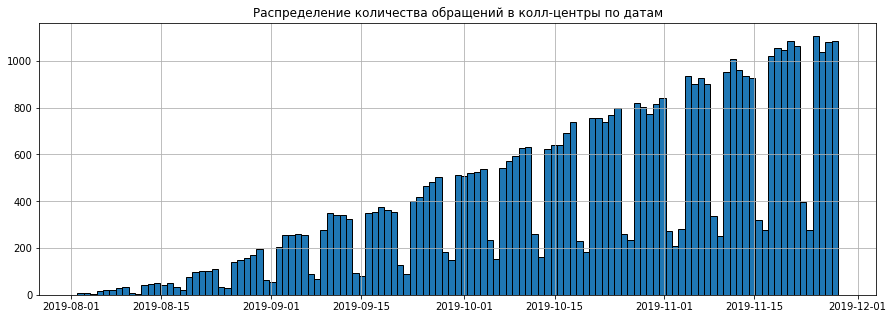

In [30]:
dff['date'].hist(bins=119, figsize=(15,5), ec='black');
plt.title('Распределение количества обращений в колл-центры по датам')
plt.show()

In [31]:
print('Имеем данные с', df['date'].min(), 'по', df['date'].max())

Имеем данные с 2019-08-02 по 2019-11-28


Данные по времени распределены по датам. Есть аггрегированные данные по звонкам за день.

In [32]:
dff['date_start'].nunique()

66

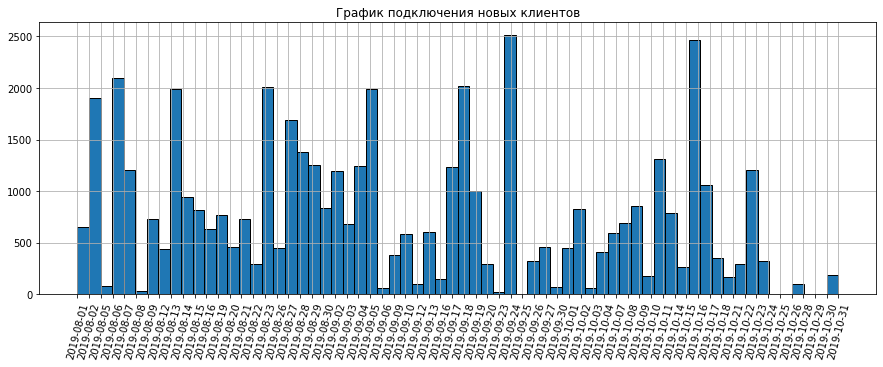

In [33]:
dff['date_start'].hist(bins=66, figsize=(15,5), ec='black', xrot=75);
plt.title('График подключения новых клиентов')
plt.show()

На графике накопления статистик видим, что данные накапливаются по нарастанию. Логично, чем дальше, тем больше клиентов, тем больше данных.

На графике подключения новых клиентов видно, что активно новые клиенты набирались в августе 2019. 

## Оценим основные метрики для колл-центров.


### Разбивка данных по типам коллцентров.

In [34]:
data = dff
data['direction'] = data['direction'].map({'in': 1, 'out': 0})

In [35]:
asd = data.groupby('user_id')['direction'].mean().reset_index()

In [36]:
dff = dff.merge(asd, on='user_id', how='outer') 

In [37]:
def income_grouped(direction_y):
    if direction_y >= 0.5:
        return 'Специализация на Входящие'
    if direction_y < 0.5:
        return 'Специализация на Исходящие'
#    if 0.4 < direction_y < 0.6:
#        return 'Без специализации'
    
dff['group'] = dff['direction_y'].apply(income_grouped)

In [38]:
dff = dff.rename(columns={'direction_x': 'direction'})

In [39]:
dff = dff.drop('direction_y', 1)

In [40]:
dff.info()
dff.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 48891
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              48892 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  int64  
 3   internal             48892 non-null  object 
 4   operator_id          48892 non-null  int64  
 5   is_missed_call       48892 non-null  object 
 6   calls_count          48892 non-null  int64  
 7   call_duration        48892 non-null  int64  
 8   total_call_duration  48892 non-null  int64  
 9   avg_wait             48892 non-null  float64
 10  tariff_plan          48892 non-null  object 
 11  date_start           48892 non-null  object 
 12  group                48892 non-null  object 
dtypes: float64(1), int64(6), object(6)
memory usage: 5.2+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_wait,tariff_plan,date_start,group
0,166377,2019-08-04,1,False,111111,True,2,0,4,2.0,B,2019-08-01,Специализация на Исходящие
1,166377,2019-08-05,0,True,880022,True,3,0,5,1.7,B,2019-08-01,Специализация на Исходящие
2,166377,2019-08-05,0,True,880020,True,1,0,1,1.0,B,2019-08-01,Специализация на Исходящие
3,166377,2019-08-05,0,True,880020,False,1,10,18,8.0,B,2019-08-01,Специализация на Исходящие
4,166377,2019-08-05,0,False,880022,True,3,0,25,8.3,B,2019-08-01,Специализация на Исходящие


Таким образом мы разделили наши данные на 2 группы.

В первой группе собраны все клиенты и операторы специализирующиеся на Исходящих звонках.

Во второй группе собраны все клиенты и операторы специализирующиеся на Входящих звонках.


In [41]:
df_in = dff[dff['group']=='Специализация на Входящие']
df_out = dff[dff['group']=='Специализация на Исходящие']

### Сравнение групп

Теперь мы можем более подробно изучить каждую группу и сравнить их между собой.

In [42]:
print('Количество уникальных клиентов в группе Входящих:', df_in['user_id'].nunique())
print('Количество уникальных клиентов в группе Исходящих:', df_out['user_id'].nunique())

Количество уникальных клиентов в группе Входящих: 177
Количество уникальных клиентов в группе Исходящих: 130


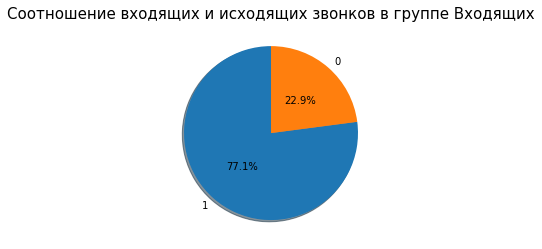

In [43]:
pie_df_in = df_in[df_in['internal']==False].groupby('direction')['calls_count'].sum().reset_index().sort_values(by='direction', ascending=False)
labels = pie_df_in['direction']
fig1, ax1 = plt.subplots()
ax1.pie(pie_df_in['calls_count'], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.5, )
plt.title("Соотношение входящих и исходящих звонков в группе Входящих", fontsize=15);

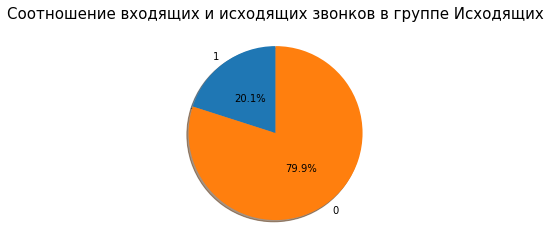

In [44]:
pie_df_out = df_out[df_out['internal']==False].groupby('direction')['calls_count'].sum().reset_index().sort_values(by='direction', ascending=False)
labels = pie_df_out['direction']
fig1, ax1 = plt.subplots()
ax1.pie(pie_df_out['calls_count'], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.5, )
plt.title("Соотношение входящих и исходящих звонков в группе Исходящих", fontsize=15);

### Оценим метрики на всех группах

#### Группа Входящих

In [45]:
df_in[['direction', 'calls_count', 'call_duration', 'total_call_duration', 'avg_wait']].describe().T

,count,mean,std,min,25%,50%,75%,max
direction,10463.0,0.752748,0.431435,0.0,1.0,1.0,1.0,1.0
calls_count,10463.0,6.309758,13.297779,1.0,1.0,2.0,6.0,341.0
call_duration,10463.0,364.525471,980.345296,0.0,0.0,20.0,302.0,20223.0
total_call_duration,10463.0,479.898022,1117.488853,0.0,28.0,102.0,431.0,20289.0
avg_wait,10463.0,18.249947,15.429503,0.0,8.0,15.0,25.1,294.0


По данным видно что на одного оператора приходится в среднем 6 звонков, средней продолжительностью 364 секунды.

##### CAR, процент потерянных вызовов.

In [46]:
(df_in.loc[(df_in['internal']==False) & (df_in['is_missed_call']==True)].groupby('operator_id')['calls_count'].agg('sum')).sum()/(df_in.loc[(df_in['internal']==False)].groupby('operator_id')['calls_count'].agg('sum')).sum()*100

39.86526923135943

Процент пропущенных звонков - 39,86%.

Это критически много. Среднеотраслевой стандарт - 5-8% (согласно данных Манго, https://www.mango-office.ru/products/contact-center/vozmozhnosti/kpi/)

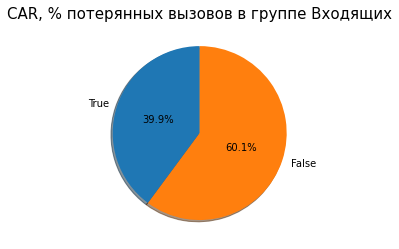

In [47]:
pie_df_in = df_in.loc[(df_in['internal']==False)].groupby('is_missed_call')['calls_count'].sum().reset_index().sort_values(by='is_missed_call', ascending=False)
labels = pie_df_in['is_missed_call']
fig1, ax1 = plt.subplots()
ax1.pie(pie_df_in['calls_count'], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.5, )
plt.title("CAR, % потерянных вызовов в группе Входящих", fontsize=15);

##### ASA (Average Speed of Answer).

In [48]:
df_in['avg_wait'].mean()

18.24994743381439

Cреднее время ожидания ответа клиентом - 18.2 секунды. Что вписывается в среднеотраслевые стандарты - 28 секунд.

(https://www.mango-office.ru/products/contact-center/vozmozhnosti/kpi/)

##### ATT (Average Talk Time).

In [49]:
df_in['call_duration'].describe()

count    10463.000000
mean       364.525471
std        980.345296
min          0.000000
25%          0.000000
50%         20.000000
75%        302.000000
max      20223.000000
Name: call_duration, dtype: float64

(-50.0, 800.0)

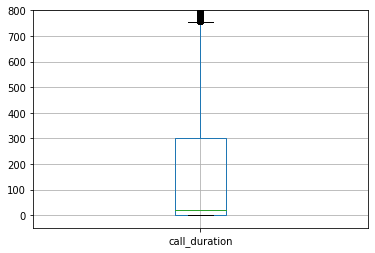

In [50]:
df_in.boxplot('call_duration')
plt.ylim([-50,800])

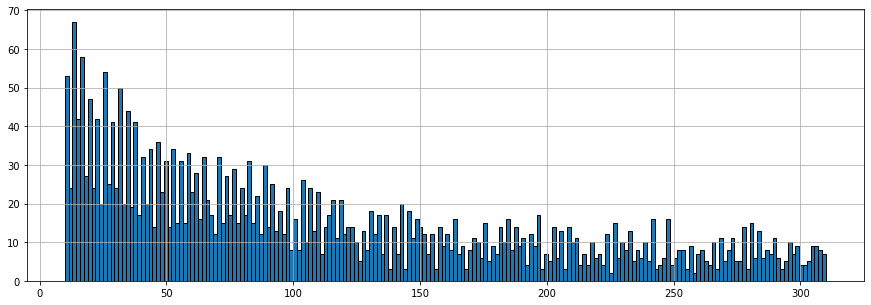

In [51]:
df_in.loc[(df_in['call_duration'] <= 310) & (df_in['call_duration'] >= 10)]['call_duration'].hist(bins=200, figsize=(15,5), ec='black');

Среднее время разговора с оператором - 364 секунд.

При этом на графике наглядно видно, что наши данные распределены очень жизненно. Большая часть разговоров заканчивается доволльно быстро, медиана - 20 сек.

И все же, исходя из специфики колл-центра (Входящие звонки) считаю разговор в 6 минут правдоподобным, но это скорее исключение, чем правило, поэтому тут возьмем медиану.

##### ATA (Average Time to Abandon).

In [52]:
df_in.loc[(df_in['internal']==False) & (df_in['is_missed_call']==True)].describe() 

,user_id,direction,operator_id,calls_count,call_duration,total_call_duration,avg_wait
count,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000
mean,167293.577398,0.758706,344439.714446,5.836666,0.424624,114.848798,19.369692
std,570.398415,0.427916,366257.291745,13.996005,6.082531,337.669841,19.259145
min,166391.000000,0.000000,111111.000000,1.000000,0.000000,0.000000,0.000000
25%,166813.000000,1.000000,111111.000000,1.000000,0.000000,7.000000,3.000000
50%,167141.000000,1.000000,111111.000000,2.000000,0.000000,31.000000,16.000000
75%,167792.000000,1.000000,892537.000000,5.000000,0.000000,87.000000,29.200000
max,168598.000000,1.000000,970486.000000,341.000000,147.000000,9272.000000,294.000000


В среднем клиенты ложили трубку после 19 секунд ожидания.

Еще хотел взглянуть на долю переводов на других операторов, вдруг там что-то интересное.

In [53]:
(df_in.loc[df_in['internal']==True]['calls_count'].sum()/df_in['calls_count'].sum())*100

1.2905375725170027

Всего 1,3% звонков было переведено на другого оператора. Ничего необычного, хороший показатель.

##### Вывод по метрикам для Входящих.

Метрики для группы Входящих:
- CAR (общий % потерянных вызовов) = 39.8%
- ASA (среднее время ожидания ответа клиентом) = 18,2 секунд.
- ATT (среднее время разговора оператора с клиентом) = 20 секунд.
- Среднее время ожидания оператором ответа клиента до сброса = 19 секунд.
- Перевод входящих на других операторов - 1,3%.

#### Группа Исходящих

In [54]:
df_out[['direction', 'calls_count', 'call_duration', 'total_call_duration', 'avg_wait']].describe().T

,count,mean,std,min,25%,50%,75%,max
direction,38429.0,0.312759,0.463623,0.0,0.0,0.0,1.0,1.0
calls_count,38429.0,19.268391,71.230771,1.0,2.0,5.0,15.0,4817.0
call_duration,38429.0,1005.193135,4221.961465,0.0,0.0,46.0,686.0,144395.0
total_call_duration,38429.0,1343.868016,4976.398905,0.0,56.0,256.0,1079.0,166155.0
avg_wait,38429.0,16.448703,13.393437,0.0,8.0,14.4,21.7,465.0


Среднее количество звонков, которые совершает оператор - 19. Средняя их продолжительность 1005 секунд, но считаю что тут необходимо смотреть на медиану - 46 секунд.

##### CAR, процент потерянных вызовов.

In [55]:
(df_out.loc[(df_out['internal']==False) & (df_out['is_missed_call']==True)].groupby('operator_id')['calls_count'].agg('sum')).sum()/(df_out.loc[(df_out['internal']==False)].groupby('operator_id')['calls_count'].agg('sum')).sum()*100

47.306450591884534

Процент пропущенных звонков - 47%.

Слишком много. Среднеотраслевой стандарт - 5-8% 

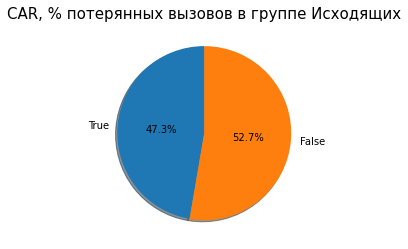

In [56]:
pie_df_out = df_out.loc[(df_out['internal']==False)].groupby('is_missed_call')['calls_count'].sum().reset_index().sort_values(by='is_missed_call', ascending=False)
labels = pie_df_out['is_missed_call']
fig1, ax1 = plt.subplots()
ax1.pie(pie_df_out['calls_count'], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.5, )
plt.title("CAR, % потерянных вызовов в группе Исходящих", fontsize=15);

##### ASA (Average Speed of Answer).

In [57]:
df_out['avg_wait'].mean()

16.448702802570974

Cреднее время ожидания ответа клиентом - 16.4 секунды. Что вписывается в среднеотраслевые стандарты - 28 секунд.

##### ATT (Average Talk Time).


In [58]:
df_out['call_duration'].describe()

count     38429.000000
mean       1005.193135
std        4221.961465
min           0.000000
25%           0.000000
50%          46.000000
75%         686.000000
max      144395.000000
Name: call_duration, dtype: float64

(-50.0, 1750.0)

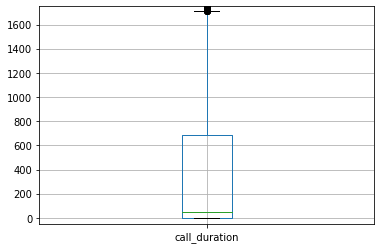

In [59]:
df_out.boxplot('call_duration')
plt.ylim([-50,1750])

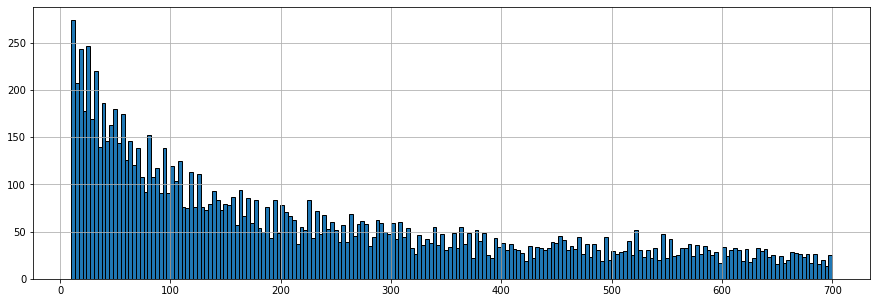

In [60]:
df_out.loc[(df_out['call_duration'] <= 700) & (df_out['call_duration'] >= 10)]['call_duration'].hist(bins=200, figsize=(15,5), ec='black');

Среднее время разговора с оператором - 1005 секунд.

Медиана отражает более правдоподобное значение - 46 секунд.

Что вполне логично, так как подавляющее большинство людей услышав рекламное предложение быстро завершали разговор. А более вежливые люди все таки выслушывали сообщение в течении почти минуты.

##### ATA (Average Time to Abandon).

In [61]:
df_out.loc[(df_out['internal']==False) & (df_out['is_missed_call']==True)].describe() 

,user_id,direction,operator_id,calls_count,call_duration,total_call_duration,avg_wait
count,14224.000000,14224.000000,14224.000000,14224.000000,14224.000000,14224.000000,14224.000000
mean,167301.989314,0.292182,700904.747539,24.167463,1.404738,491.671611,21.765882
std,626.712890,0.454782,357452.244853,94.757672,21.333359,1633.542117,16.029044
min,166377.000000,0.000000,111111.000000,1.000000,0.000000,0.000000,0.000000
25%,166680.000000,0.000000,111111.000000,2.000000,0.000000,31.000000,11.500000
50%,167172.000000,0.000000,902510.000000,5.000000,0.000000,112.000000,21.000000
75%,167828.000000,1.000000,928886.000000,18.000000,0.000000,385.000000,29.300000
max,168606.000000,1.000000,973120.000000,4817.000000,741.000000,45312.000000,465.000000


В среднем операторы ждут ответа 21 секунду.

##### Вывод по метрикам для Исходящих.

Метрики для группы Исходящих:
- CAR (общий % потерянных вызовов) = 47%
- ASA (среднее время ожидания ответа оператором) = 16,4 секунд
- ATT (среднее время разговора оператора с клиентом) = 46 секунд.
- В среднем операторы ждут ответа 21 секунду.

#### Общий вывод по метрикам

Мы разбили клиентов на две группы со специализациями Входящие, Исходящие.

И посчитали для каждой группы метрики эффективности колл-центров.

Метрики мы нашли на сайте https://wilstream.ru/stati/kpi-koll-tsentra/

К сожалению, не для всех метрик у нас есть данные, поэтому посчитали только те, для которых эти данные есть.

В итоге мы видим, что во всех трех группах очень большой процент потерянных вызовов, от 39 до 47 процентов. Над этим показателем нужно работать в первую очередь.

Среднее время ожидания ответа клиентом у всех групп на достаточно хорошем уровне, от 16 до 18 секунд.

Среднее время разговора правдоподобно для каждой из групп:

- У Входящих - 364 секунды (так как клиенты сами звонят решить свою проблему)
- У Исходящих - 46 секунд (так как мало кто готов выслушивать рекламные предложения)

Среднее время ожидания клиентом ответа оператора до сброса звонка у все трех групп примерно одинаковое - 19-21 секунд.

### Получаем список клиентов с неэффективными операторами.

Так как мы уже выяснили, что слабое место операторов в нашем датасете это процент пропущенных звонков, то более подробно остановимся на нем и будем выявлять самых неэффективных операторов.

По мнению Манго-Телеком (популярный оператор виртуальной телефонии) отраслевой стандарт пропущенных звонков в колл-центре 5-8%., https://www.mango-office.ru/products/contact-center/vozmozhnosti/kpi/

Поднимем эту планку для наших операторов до 25%, т.е. если оператор пропустил 1 из 4 звонков, то будем считать его работу неэффективной. Будем считать это поводом провести глубокий анализ деяткельности коллцентра клиента и предложить ему варианты улучшения эффективности.

In [62]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_wait,tariff_plan,date_start
0,166377,2019-08-04,1,False,111111,True,2,0,4,2.0,B,2019-08-01
1,166377,2019-08-05,0,True,880022,True,3,0,5,1.7,B,2019-08-01
2,166377,2019-08-05,0,True,880020,True,1,0,1,1.0,B,2019-08-01
3,166377,2019-08-05,0,True,880020,False,1,10,18,8.0,B,2019-08-01
4,166377,2019-08-05,0,False,880022,True,3,0,25,8.3,B,2019-08-01


In [63]:
data['is_missed_call'] = data['is_missed_call'].map({True: 1, False: 0})

In [64]:
zxc = data.groupby(['user_id', 'operator_id'])['is_missed_call'].mean().reset_index()

In [65]:
zxc.head()

,user_id,operator_id,is_missed_call
0,166377,111111,1.000000
1,166377,880020,0.300000
2,166377,880022,0.414286
3,166377,880026,0.478022
4,166377,880028,0.405941


Мы получили список клиентов, с их операторами, у которых рассчитана доля пропущенных звонков. 

Теперь выясним кто из операторв наиболее неэффективный, оценив его по метрике "процент пропущенных звонков".

In [66]:
#исключим оператора 111111 (это общий показатель пропущенных звонков в колл-центре) и получим список клиентов, которым в первую очередь нужно подумать над эффективностью.
zxc.loc[(zxc['is_missed_call']>0.25) & (zxc['operator_id'] != 111111)]['user_id'].unique()

array([166377, 166391, 166405, 166406, 166407, 166485, 166487, 166495,
       166503, 166507, 166511, 166520, 166533, 166536, 166582, 166609,
       166619, 166658, 166660, 166669, 166677, 166678, 166680, 166688,
       166691, 166692, 166708, 166711, 166717, 166725, 166732, 166774,
       166782, 166800, 166813, 166833, 166837, 166839, 166843, 166874,
       166884, 166899, 166901, 166916, 166936, 166939, 166940, 166941,
       166946, 166971, 166974, 166983, 166993, 166997, 167002, 167004,
       167009, 167011, 167012, 167016, 167031, 167035, 167060, 167071,
       167078, 167082, 167109, 167110, 167112, 167113, 167122, 167124,
       167125, 167130, 167141, 167144, 167150, 167172, 167175, 167176,
       167180, 167183, 167185, 167188, 167189, 167235, 167250, 167263,
       167275, 167285, 167288, 167338, 167359, 167364, 167397, 167436,
       167445, 167451, 167456, 167466, 167471, 167475, 167479, 167487,
       167497, 167521, 167530, 167532, 167543, 167545, 167551, 167580,
      

**Вывод**

Мы получили список из 187 клиентов, которым в первую очередь необходимо предлагать возможные варианты улучшения эффективности.

Операторы этих клиентов пропускают четверть звонков, это примерно в пять раз больше отраслевого стандарта.

### Сформируем и проверим гипотезы

#### Гипотеза №1

Среднее время разговора в группе Входящих и Исходящих различаются.
- Н0 - Среднее время разговора в группе Входящих и Исходящих не различаются.
- Н1 - Среднее время разговора в группе Входящих и Исходящих различаются.

In [67]:
alpha = 0.05

In [68]:
results = st.ttest_ind(df_in['avg_wait'], df_out['avg_wait'])

In [69]:
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.8386240189110765e-32
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась, среднее время разговора разное.

#### Гипотеза №2

В группе Входящих количество потерянных клиентов отличается от группы Исходящих.
- Н0 - Среднее количество потерянных клиентов не различается.
- Н1 - Среднее количество потерянных клиентов различается.

In [70]:
miss_in = df_in.loc[(df_in['internal']==False) & (df_in['is_missed_call']==True)]

In [71]:
miss_out = df_out.loc[(df_out['internal']==False) & (df_out['is_missed_call']==True)]

In [72]:
results = st.ttest_ind(miss_in['calls_count'], miss_out['calls_count'])

In [73]:
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.0639033619120892e-37
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась, количество потерянных клиентов в двух группах разное.

## Общий вывод

Мы провели исследование для провайдера виртуальной телефонии "Нупозвони".

Датасет был сгруппирован по двум типам клиентов:
1. Группа Входящих - это те клиенты, которые распределяют входящие вызовы на своих операторов.
2. Группа Исходящих - это те, которые совершают исходящие вызовы силами операторов.

Обе группы были проверены с помощью метрик взятых с сайта https://wilstream.ru/stati/kpi-koll-tsentra/.

С помощью метрик удалось определить, что во всех трех группах очень большой процент потерянных вызовов, от 39 до 47 процентов. Над этим показателем нужно работать в первую очередь.

Среднее время ожидания ответа клиентом у всех групп на достаточно хорошем уровне, от 16 до 18 секунд.

Среднее время разговора правдоподобно для каждой из групп:
- У Входящих - 364 секунды (так как клиенты сами звонят решить свою проблему)
- У Исходящих - 46 секунд (так как мало кто готов выслушивать рекламные предложения)

Среднее время ожидания клиентом ответа оператора до сброса звонка у все трех групп примерно одинаковое - 19-21 секунд.

Так же были сформированы и проверены две гипотезы:
- Среднее время разговора в группе Входящих и Исходящих различаются.
- В группе Входящих количество потерянных клиентов отличается от группы Исходящих.

Обе гипотезы подтвердились.

На основании проделанной работы можно сделать вывод, что **главная проблема эффективности операторов это пропущенные звонки**, и рекомендовать заказчику уделить пристальное внимание такому показателю как CAR (Call Abandon Rate) или Общий % потерянных вызовов. В обеих группах чуть ли не половина звонков пропускается.

Более детальное изучение метрики "процента пропущенных звонков" подвердило проблему.

Мы получили список из 187 клиентов, которым в первую очередь необходимо предлагать возможные варианты улучшения эффективности.

Операторы этих клиентов пропускают четверть звонков, это примерно в пять раз больше отраслевого стандарта.



Эти клиенты в первую очередь нуждаются в решении проблемы эффективности операторов:

166377, 166391, 166405, 166406, 166407, 166485, 166487, 166495,
       166503, 166507, 166511, 166520, 166533, 166536, 166582, 166609,
       166619, 166658, 166660, 166669, 166677, 166678, 166680, 166688,
       166691, 166692, 166708, 166711, 166717, 166725, 166732, 166774,
       166782, 166800, 166813, 166833, 166837, 166839, 166843, 166874,
       166884, 166899, 166901, 166916, 166936, 166939, 166940, 166941,
       166946, 166971, 166974, 166983, 166993, 166997, 167002, 167004,
       167009, 167011, 167012, 167016, 167031, 167035, 167060, 167071,
       167078, 167082, 167109, 167110, 167112, 167113, 167122, 167124,
       167125, 167130, 167141, 167144, 167150, 167172, 167175, 167176,
       167180, 167183, 167185, 167188, 167189, 167235, 167250, 167263,
       167275, 167285, 167288, 167338, 167359, 167364, 167397, 167436,
       167445, 167451, 167456, 167466, 167471, 167475, 167479, 167487,
       167497, 167521, 167530, 167532, 167543, 167545, 167551, 167580,
       167621, 167626, 167634, 167645, 167650, 167653, 167654, 167716,
       167727, 167742, 167747, 167756, 167759, 167799, 167805, 167816,
       167819, 167827, 167828, 167829, 167852, 167888, 167923, 167947,
       167949, 167955, 167958, 167969, 167977, 167989, 167994, 167995,
       167999, 168000, 168004, 168008, 168010, 168018, 168021, 168025,
       168047, 168062, 168064, 168073, 168091, 168093, 168097, 168105,
       168121, 168128, 168154, 168155, 168185, 168187, 168193, 168221,
       168225, 168228, 168252, 168253, 168271, 168275, 168291, 168295,
       168307, 168336, 168361, 168412, 168416, 168466, 168473, 168481,
       168601, 168603, 168606.

In [74]:
#plt.figure(figsize=(15, 5))
#plt.hist(df_in.loc[(df_in['call_duration'] >= 1) & (df_in['call_duration'] <= 1500)]['call_duration'], bins = 200, range=(0,1500), alpha=0.9, label='группа Входящие',)
#plt.hist(df_out.loc[(df_out['call_duration'] >= 1) & (df_out['call_duration'] <= 1500)]['call_duration'], bins = 200, range=(0,1500), alpha=0.3, label='группа Исходящие',)
#plt.axvline(x=20, color='b', ls=':', label='Медиана гр.Входящие')
#plt.axvline(x=46, color='orange', ls=':', label='Медиана гр.Исходящие')
#plt.axvline(x=364, color='b', ls='-.', label='Среднее гр.Входящие') 
#plt.axvline(x=1005, color='orange', ls='-.', label='Среднее гр.Исходящие')
#plt.legend(loc='upper right')
#plt.title('Сравнение средней продолжительности разговора')
#plt.show()